In [1]:
import pandas as pd
import numpy as np

np.set_printoptions(legacy="1.25")
dataurl = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

df = pd.read_csv(dataurl)

In [2]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [4]:
target_variable = "converted"
categorical_features = [
    "lead_source",
    "industry",
    # "number_of_courses_viewed",
    "employment_status",
    "location",
]
numerical_features = list(
    set(df.columns) - set(categorical_features) - set([target_variable])
)

In [5]:
numerical_features

['annual_income',
 'number_of_courses_viewed',
 'interaction_count',
 'lead_score']

In [6]:
df.isna().sum() / df.shape[0]

lead_source                 0.087551
industry                    0.091655
number_of_courses_viewed    0.000000
annual_income               0.123803
employment_status           0.068399
location                    0.043092
interaction_count           0.000000
lead_score                  0.000000
converted                   0.000000
dtype: float64

In [7]:
# Check if the missing values are presented in the features.
# If there are missing values:
# For caterogiral features, replace them with 'NA'
# For numerical features, replace with with 0.0

for col in df.columns:
    df[col] = (
        df[col].fillna("NA") if col in categorical_features else df[col].fillna(0.0)
    )

In [8]:
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

# What is the most frequent observation (mode) for the column industry?

In [9]:
df.industry.mode().values[0]

'retail'

# What are the two features that have the biggest correlation?

<Axes: >

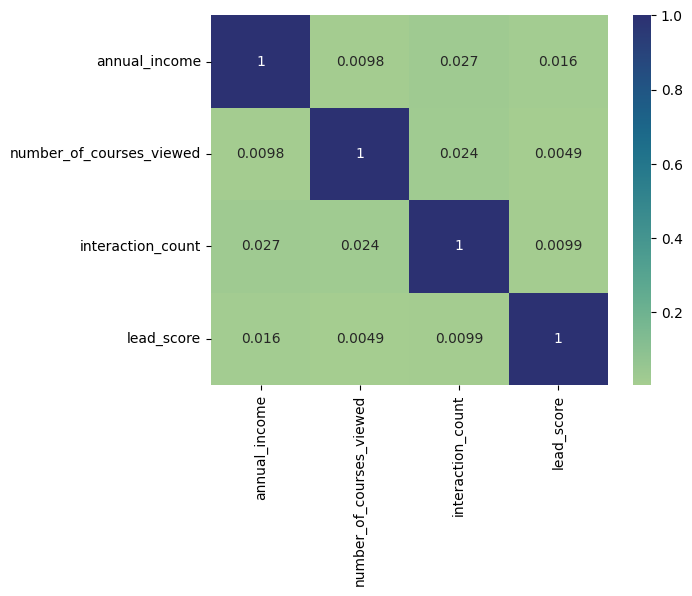

In [10]:
import seaborn as sns

corr = df[numerical_features].corr()
sns.heatmap(abs(corr), annot=True, cmap="crest")

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split


train_ratio = 0.60
test_ratio = 0.20
validation_ratio = 0.20

# train is now 60% of the entire data set
# test is 40% but we will split it again
df_train, df_test = train_test_split(
    df,
    test_size=1 - train_ratio,
    random_state=42,
)

# test is now 20% of the initial data set
# validation is now 20% of the initial data set
df_test, df_val = train_test_split(
    df_test,
    test_size=test_ratio / (test_ratio + validation_ratio),
    random_state=42,
)

y_train = df_train[target_variable].values
y_test = df_test[target_variable].values
y_val = df_val[target_variable].values

df_train = df_train.drop(columns=target_variable)
df_test = df_test.drop(columns=target_variable)
df_val = df_val.drop(columns=target_variable)

np.array([df_train.shape[0], df_val.shape[0], df_test.shape[0]]) / df.shape[0]

array([0.5998632, 0.2004104, 0.1997264])

# Question 3
Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
Round the scores to 2 decimals using round(score, 2).

Which of these variables has the biggest mutual information score?

In [12]:
from sklearn.metrics import mutual_info_score

for col in categorical_features:
    print(col, round(mutual_info_score(df_train[col], y_train), 2))

lead_source 0.03
industry 0.02
employment_status 0.02
location 0.0


In [13]:
# not required but I was curious which numerical variable was most correlated with
# the target variable
df[numerical_features].corrwith(df[target_variable])

annual_income               0.053131
number_of_courses_viewed    0.435914
interaction_count           0.374573
lead_score                  0.193673
dtype: float64

# One-hot encode categorical variables

In [14]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical_features + numerical_features].to_dict(
    orient="records"
)
val_dict = df_val[categorical_features + numerical_features].to_dict(orient="records")

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X=X_train, y=y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
model.intercept_, model.coef_

(array([-0.0592603]),
 array([[-1.85981764e-05, -1.35111322e-02,  2.99224880e-02,
          1.82178695e-02,  1.22843588e-02, -1.06173888e-01,
         -2.10082113e-02,  5.41017584e-02, -2.49752388e-02,
         -2.15300885e-02, -1.13399746e-02, -4.04064976e-03,
         -1.60840620e-02, -1.43838370e-02,  2.98640270e-01,
          4.70610362e-02,  8.71290786e-03, -1.44604312e-02,
         -1.37361363e-02, -9.58653120e-02,  7.11476246e-02,
         -1.50589565e-02,  4.50077429e-03, -1.43065964e-02,
         -1.18392102e-02, -9.73476910e-03,  4.62393212e-03,
          6.55132004e-03, -2.10520303e-02, -1.80037241e-02,
          4.50797525e-01]]))

In [17]:
y_pred = model.predict_proba(X_val)[:, 1]

In [18]:
(y_val == (y_pred >= 0.50)).mean().round(2)

0.7

In [19]:
# wrong but a value that is one of the answers
(y_train == (model.predict_proba(X_train)[:, 1] >= 0.5)).mean().round(2)

0.75

# Feature-elimination

In [20]:
try_exclude_cols = ["industry", "employment_status", "lead_score"]
orig_accuracy = (y_val == (y_pred >= 0.5)).mean()

for exclude_col in try_exclude_cols:
    # exclude the col from either list
    categoricals = [i for i in categorical_features if i != exclude_col]
    numericals = [i for i in numerical_features if i != exclude_col]

    if len(categoricals) < len(categorical_features):
        print(f"feature {exclude_col} removed from categorical features")
    elif len(numericals) < len(numerical_features):
        print(f"feature {exclude_col} removed from numerical features")

    # one hot encode
    dv = DictVectorizer(sparse=False)
    train_dic = df_train[categoricals + numericals].to_dict(orient="records")
    val_dic = df_val[categoricals + numericals].to_dict(orient="records")

    # xtrain and xval change since we are excluding different columns
    # but y_train and y_val stay the same since our target variable
    # is the same
    xt = dv.fit_transform(train_dic)
    xv = dv.transform(val_dic)

    # train model
    model = LogisticRegression(
        solver="liblinear", C=1.0, max_iter=1000, random_state=42
    )
    model.fit(X=xt, y=y_train)
    yp = model.predict(X=xv)

    accuracy_without_feature = (y_val == (yp >= 0.5)).mean()
    accuracy_diff = abs(accuracy_without_feature - orig_accuracy)
    print(f"{exclude_col=} {accuracy_diff=:.4f}")
    print()

feature industry removed from categorical features
exclude_col='industry' accuracy_diff=0.0068

feature employment_status removed from categorical features
exclude_col='employment_status' accuracy_diff=0.0000

feature lead_score removed from numerical features
exclude_col='lead_score' accuracy_diff=0.0102



# regularization

In [44]:
cvals = np.logspace(-5, 5, 11)
accuracies = {}

for c in cvals:
    model = LogisticRegression(solver="liblinear", C=c, max_iter=1000, random_state=42)
    model.fit(X=X_train, y=y_train)
    yp = model.predict_proba(X=X_val)[:, 1]

    # calculate accuracy
    accuracy = (y_val == (yp >= 0.5)).mean().round(3)
    accuracies[c] = accuracy

In [45]:
for c, accuracy in accuracies.items():
    print(f"{c=} and {accuracy=}")

c=1e-05 and accuracy=0.59
c=0.0001 and accuracy=0.59
c=0.001 and accuracy=0.594
c=0.01 and accuracy=0.706
c=0.1 and accuracy=0.696
c=1.0 and accuracy=0.696
c=10.0 and accuracy=0.696
c=100.0 and accuracy=0.696
c=1000.0 and accuracy=0.696
c=10000.0 and accuracy=0.696
c=100000.0 and accuracy=0.696


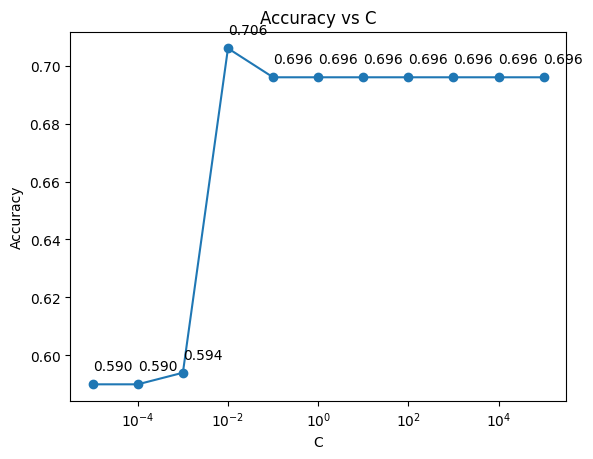

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accuracies.keys(), accuracies.values(), marker="o")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy vs C")
for c, accuracy in accuracies.items():
    plt.annotate(
        f"{accuracy:.3f}",
        (c, accuracy),
        textcoords="offset points",
        xytext=(0, 10),
        ha="left",
    )
plt.show()